# Data Set Information:

https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#

Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.

In [174]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

In [175]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


# 1. EDA

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [177]:
df.shape

(48204, 9)

In [178]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


**Удалим неинтересующие нас столбцы**

In [179]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [180]:
df = df.drop(columns=['rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description'], axis=1)
df.head(2)

,holiday,temp,date_time,traffic_volume
0,None,288.28,2012-10-02 09:00:00,5545
1,None,289.36,2012-10-02 10:00:00,4516


In [181]:
df['holiday'].unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [182]:
df['temp'].unique()

array([288.28, 289.36, 289.58, ..., 306.08, 304.41, 304.9 ])

**Конверитируем колонку date_time в datetime и устанавливаем её как индекс**

In [183]:
df['date_time'] =  pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

In [184]:
df = df.set_index(pd.DatetimeIndex(df['date_time']))

**Проверим дубликаты**

In [185]:
df.duplicated().sum()

7551

In [186]:
df = df.drop_duplicates()

In [187]:
df.duplicated().sum()

0

In [188]:
df.shape

(40653, 4)

**Взглянем на пропущенные значения**

In [189]:
df.isna().sum()

holiday           0
temp              0
date_time         0
traffic_volume    0
dtype: int64

**Временной промежуток в датасете**

In [190]:
len(df['date_time'].unique())

40575

А вот реальный промежуток...

In [191]:
pd.date_range(start='2012-10-02 09:00:00', end='2018-09-30 23:00:00', freq='H')

DatetimeIndex(['2012-10-02 09:00:00', '2012-10-02 10:00:00',
               '2012-10-02 11:00:00', '2012-10-02 12:00:00',
               '2012-10-02 13:00:00', '2012-10-02 14:00:00',
               '2012-10-02 15:00:00', '2012-10-02 16:00:00',
               '2012-10-02 17:00:00', '2012-10-02 18:00:00',
               ...
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', length=52551, freq='H')

Видим пропуски. Реальная временная метка, **length=52551**

Поработаем над пропусками

In [192]:
# Создадим  DataFrame без пропусков во времени
data = pd.DataFrame({'real_date_time': pd.date_range(start='2012-10-02 09:00:00', end='2018-09-30 23:00:00', freq='H')})

In [193]:
# Приведём к формату datetime
data['date_time'] =  pd.to_datetime(data['real_date_time'], format='%Y-%m-%d %H:%M:%S')

In [194]:
# Сделаем индексы
data = data.set_index(pd.DatetimeIndex(data['date_time']))

In [195]:
data.head(2)

,real_date_time,date_time
date_time,,
2012-10-02 09:00:00,2012-10-02 09:00:00,2012-10-02 09:00:00
2012-10-02 10:00:00,2012-10-02 10:00:00,2012-10-02 10:00:00


In [196]:
data = data.drop(columns=['date_time'], axis=1)

In [197]:
data.head(2)

,real_date_time
date_time,
2012-10-02 09:00:00,2012-10-02 09:00:00
2012-10-02 10:00:00,2012-10-02 10:00:00


In [198]:
len(data)

52551

In [199]:
len(df)

40653

In [200]:
df.head(2)

,holiday,temp,date_time,traffic_volume
date_time,,,,
2012-10-02 09:00:00,None,288.28,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,None,289.36,2012-10-02 10:00:00,4516


In [201]:
df_new = data.merge(df, how='left', left_on='real_date_time', right_index=True)

In [202]:
df_new = df_new.set_index('date_time')

In [203]:
len(df_new)

52629

In [204]:
df_new.head(3)

,real_date_time,holiday,temp,traffic_volume
date_time,,,,
2012-10-02 09:00:00,2012-10-02 09:00:00,None,288.28,5545.0
2012-10-02 10:00:00,2012-10-02 10:00:00,None,289.36,4516.0
2012-10-02 11:00:00,2012-10-02 11:00:00,None,289.58,4767.0


In [205]:
df_new = df_new.drop(columns=['real_date_time'], axis=1)

In [206]:
df = df_new.interpolate(method='linear')
df.head(3)

,holiday,temp,traffic_volume
date_time,,,
2012-10-02 09:00:00,None,288.28,5545.0
2012-10-02 10:00:00,None,289.36,4516.0
2012-10-02 11:00:00,None,289.58,4767.0


**Попробуем взять только данные с июня 2018 по 30 сентября 2018**

In [207]:
df = df['2018-06-01':'2018-09-30']
df.head()

,holiday,temp,traffic_volume
date_time,,,
2018-06-01 00:00:00,None,294.28,786.0
2018-06-01 01:00:00,None,293.22,497.0
2018-06-01 02:00:00,None,292.22,346.0
2018-06-01 03:00:00,None,291.43,395.0
2018-06-01 04:00:00,None,291.15,872.0


In [208]:
df.shape

(2923, 3)

**Отложим последние две недели из датасета для тестов**

In [209]:
split_date = '2018-09-16'
df_train = df.iloc[df.index < split_date].copy()
df_test = df.iloc[df.index > split_date].copy()

In [210]:
(df_train.shape, df_test.shape)

((2563, 3), (359, 3))

In [211]:
def plot_data(df):
  """ Отрисовка временного ряда """
  plt.figure(figsize=(18,8))
  plt.plot(df_train.traffic_volume)
  plt.plot(df_test.traffic_volume)
  plt.show()

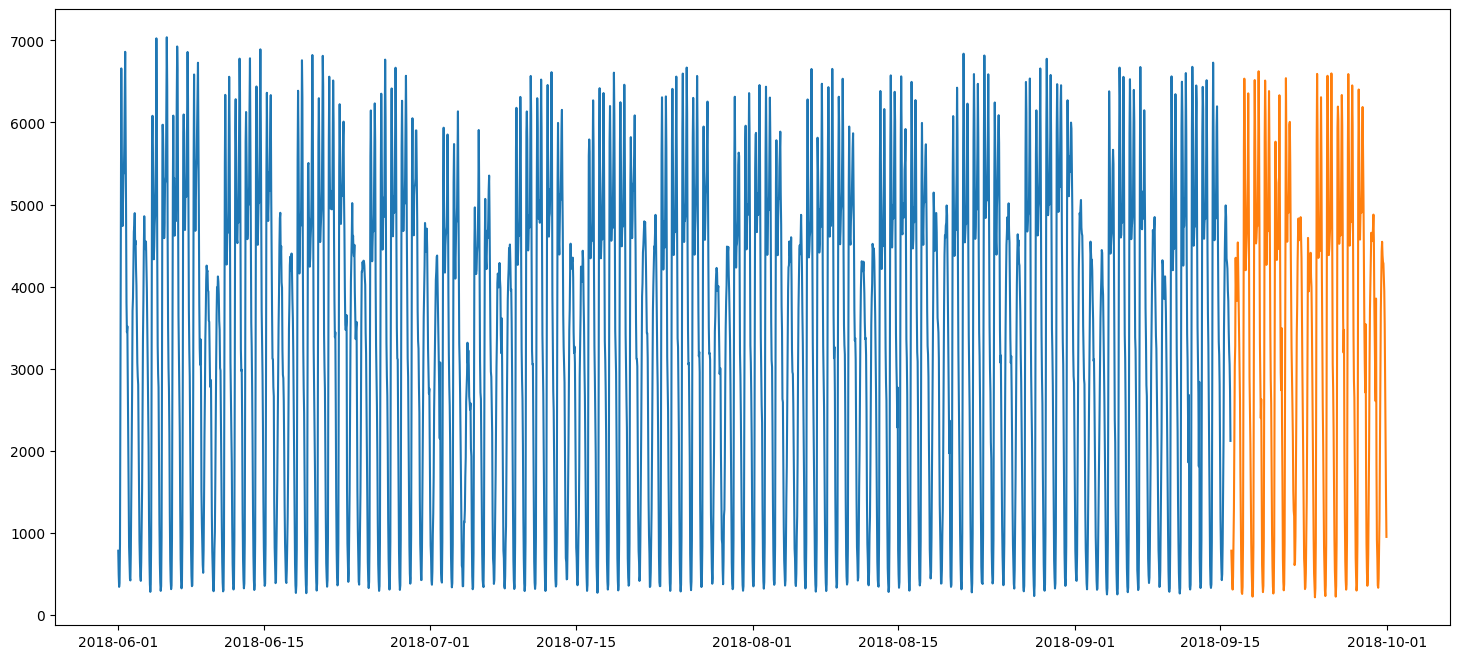

In [212]:
plot_data(df)

# Генерируем дополнительные признаки

In [213]:
def create_features(df, label=None):
    """
    Генерируем дополнительные признаки из datetime
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.weekofyear
    
    X = df[['hour','day_of_week','quarter','month','year','day_of_year','day_of_month','week_of_year']]
    
    if label:
        y = df[label]
        return X, y
    return X

**Метрики**

In [214]:
def mean_absolute_percentage_error(y_true, y_pred): 

  """ MAPE """
  
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [215]:
def error_metrics(y_true, y_pred):

  """ Подсчёт метрик и вывод на экран """
  
  print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
  print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
  print('Mean Absolute Percentage Error: {:.2f} %'.format(mean_absolute_percentage_error(y_true, y_pred)))

# Baseline

In [216]:
new_features_train = create_features(df_train)

In [217]:
df_groupby_train = df_train.groupby(["day_of_week", "hour"])["traffic_volume"].mean()

In [218]:
new_features_test = create_features(df_test)

In [219]:
df_groupby_test = df_test.groupby(["day_of_week", "hour"])["traffic_volume"].mean()

Интересно, какие метрики покажет Baseline

In [220]:
error_metrics(df_groupby_train, df_groupby_test)

Mean Absolute Error: 169.94
Root Mean Squared Error: 230.06
Mean Absolute Percentage Error: 7.27 %


**Деление на train и test**

In [221]:
X_train, y_train = create_features(df_train, label='traffic_volume')
X_test, y_test = create_features(df_test, label='traffic_volume')

In [222]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2563, 8), (359, 8), (2563,), (359,))

# LinearRegression

In [223]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [224]:
%%time
y_pred = lr.predict(X_test)

CPU times: user 1.46 ms, sys: 688 µs, total: 2.15 ms
Wall time: 1.9 ms


In [225]:
def plot_predictions(y_pred):
  """ Отрисока предсказаний """
  plt.figure(figsize=(15,6))
  plt.plot(df_test.index, pd.DataFrame(df_test.traffic_volume), marker='.', label="actual")
  plt.plot(df_test.index, y_pred, 'r', label="prediction")
  plt.ylabel('Traffic Volume', size=15)
  plt.xlabel('Date', size=15)
  plt.legend(fontsize=13)
  plt.show()

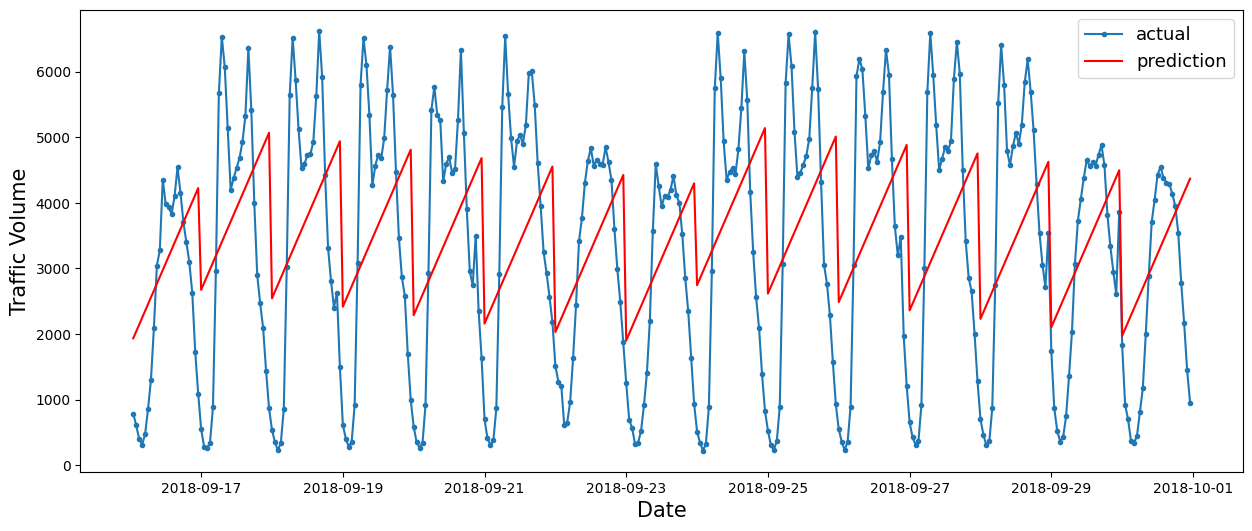

In [226]:
plot_predictions(y_pred)

In [227]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 1568.33
Root Mean Squared Error: 1802.91
Mean Absolute Percentage Error: 141.51 %


In [228]:
def plotCoefficients(model, X_train):
    """
    Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(8, 5))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

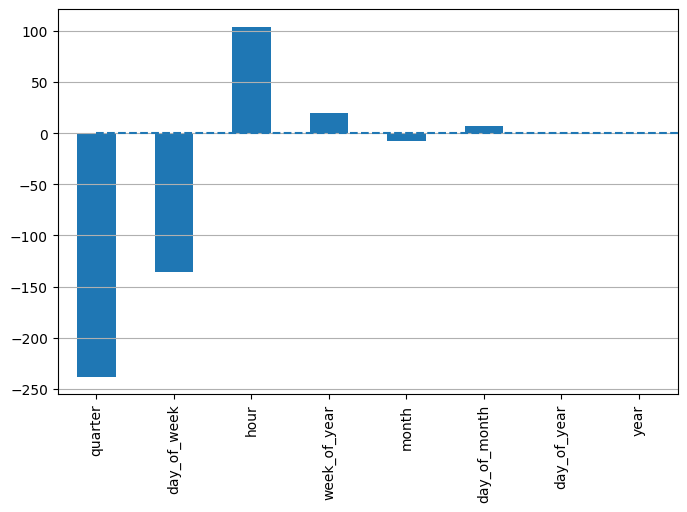

In [229]:
plotCoefficients(lr, X_train)

# RandomForestClassifier

In [230]:
%%time
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf.fit(X_train, y_train)

CPU times: user 313 ms, sys: 0 ns, total: 313 ms
Wall time: 318 ms


RandomForestClassifier(max_depth=3, random_state=42)

In [231]:
%%time
y_pred = rf.predict(X_test)

CPU times: user 214 ms, sys: 1.48 ms, total: 215 ms
Wall time: 215 ms


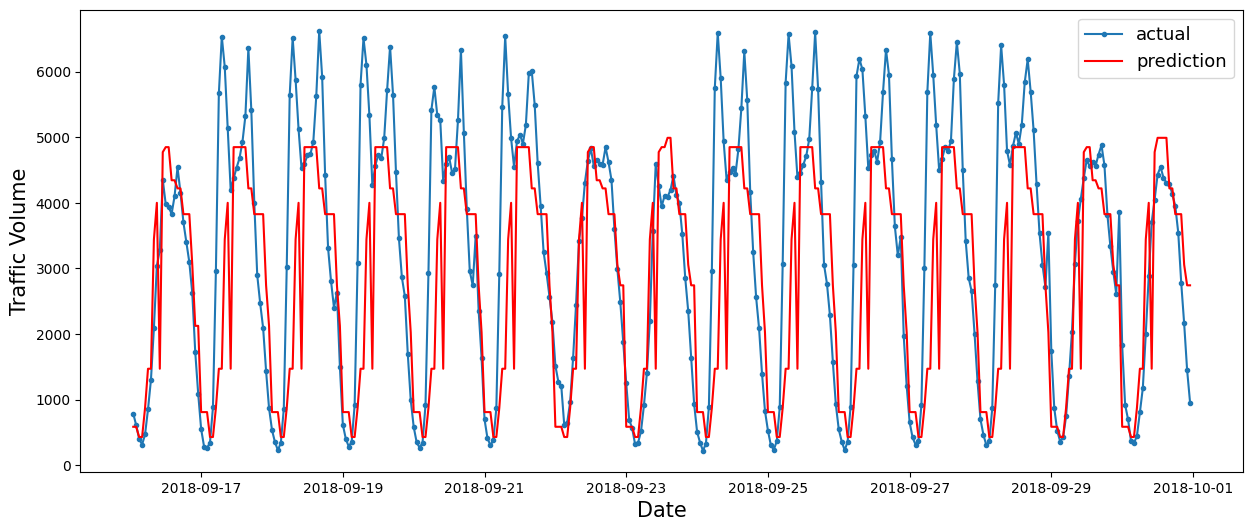

In [232]:
plot_predictions(y_pred)

In [233]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 1005.28
Root Mean Squared Error: 1526.81
Mean Absolute Percentage Error: 40.44 %


# GradientBoostingRegressor

In [234]:
%time
gb = GradientBoostingRegressor(n_estimators=100)
gb.fit(X_train, y_train)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.53 µs


GradientBoostingRegressor()

In [235]:
%%time
y_pred = gb.predict(X_test)

CPU times: user 1.43 ms, sys: 1.31 ms, total: 2.75 ms
Wall time: 5.55 ms


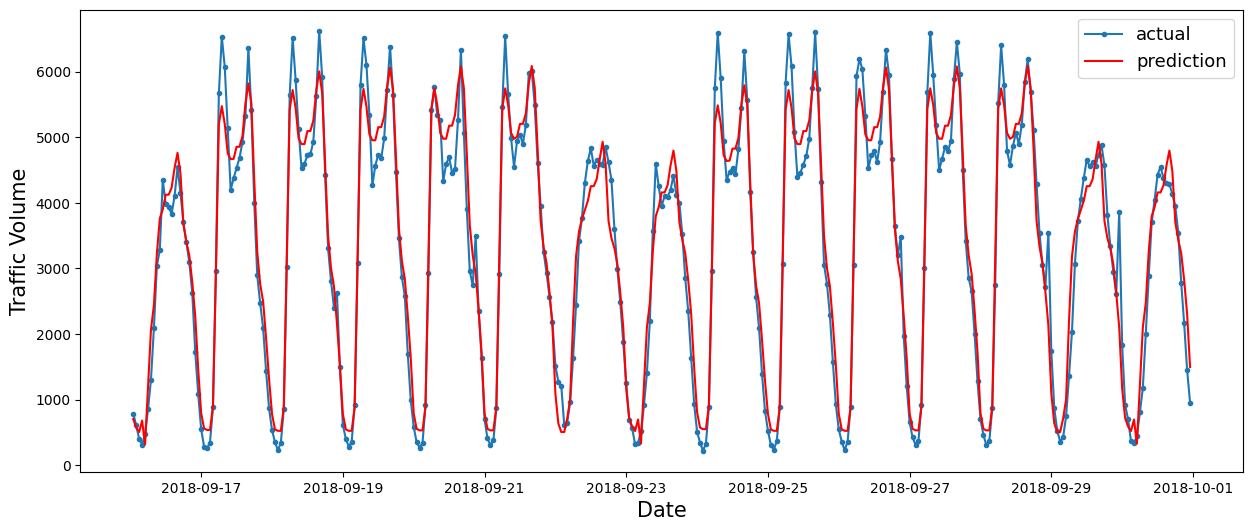

In [236]:
plot_predictions(y_pred)

In [237]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 312.54
Root Mean Squared Error: 395.68
Mean Absolute Percentage Error: 18.56 %


# XGBRegressor

In [238]:
%%time
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(X_train, y_train)

CPU times: user 307 ms, sys: 7.69 ms, total: 315 ms
Wall time: 185 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [239]:
%%time
y_pred = reg.predict(X_test)

CPU times: user 3.67 ms, sys: 1.48 ms, total: 5.15 ms
Wall time: 5.15 ms


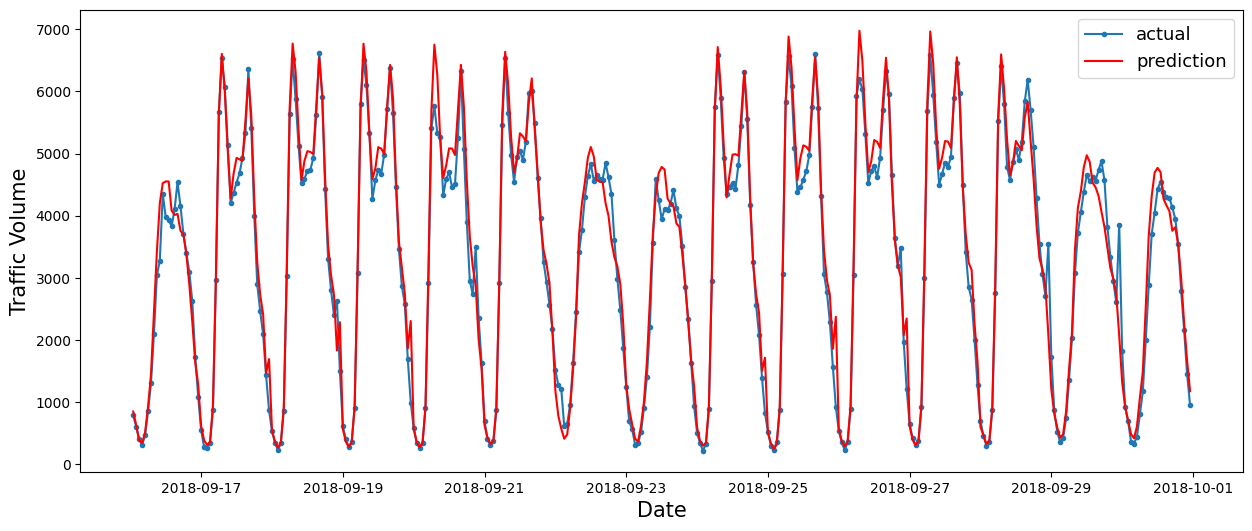

In [240]:
plot_predictions(y_pred)

In [241]:
error_metrics(df_test['traffic_volume'], y_pred)

Mean Absolute Error: 236.67
Root Mean Squared Error: 343.56
Mean Absolute Percentage Error: 10.03 %


# Prophet

In [242]:
# !pip install prophet

In [243]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

df_fbp = pd.DataFrame()
df_fbp["ds"] = pd.to_datetime(df.index)
df_fbp["y"] = df['traffic_volume'].values

In [244]:
df_fbp.head()

,ds,y
0,2018-06-01 00:00:00,786.0
1,2018-06-01 01:00:00,497.0
2,2018-06-01 02:00:00,346.0
3,2018-06-01 03:00:00,395.0
4,2018-06-01 04:00:00,872.0


In [245]:
fb_y_train = df_fbp.iloc[:-359].copy()
fb_y_test = df_fbp.iloc[-359:].copy()
fb_y_val = fb_y_test[["ds"]].copy()

In [246]:
fbmodel = Prophet()
fbmodel.fit(fb_y_train)

forecast = fbmodel.predict(fb_y_val)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd2x6_e4p/27ufp1xl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd2x6_e4p/tz9k31l8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50643', 'data', 'file=/tmp/tmpd2x6_e4p/27ufp1xl.json', 'init=/tmp/tmpd2x6_e4p/tz9k31l8.json', 'output', 'file=/tmp/tmpd2x6_e4p/prophet_modelcei5isk0/prophet_model-20230403092418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:24:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:24:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [247]:
forecast.tail(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
357,2018-09-30 22:00:00,3388.213990,972.952186,2951.635206,3376.153711,3399.818532,-1463.200278,-1463.200278,-1463.200278,-1165.330599,-1165.330599,-1165.330599,-297.869679,-297.869679,-297.869679,0.0,0.0,0.0,1925.013712
358,2018-09-30 23:00:00,3388.223705,524.880100,2546.455464,3376.123141,3399.881583,-1826.452106,-1826.452106,-1826.452106,-1565.370108,-1565.370108,-1565.370108,-261.081997,-261.081997,-261.081997,0.0,0.0,0.0,1561.771600


In [248]:
forecast_pred = forecast['yhat'].copy().astype(np.float32)

In [249]:
forecast_test = fb_y_test['y'].copy().astype(np.float32)

In [250]:
error_metrics(forecast_test, forecast_pred)

Mean Absolute Error: 618.01
Root Mean Squared Error: 821.33
Mean Absolute Percentage Error: nan %


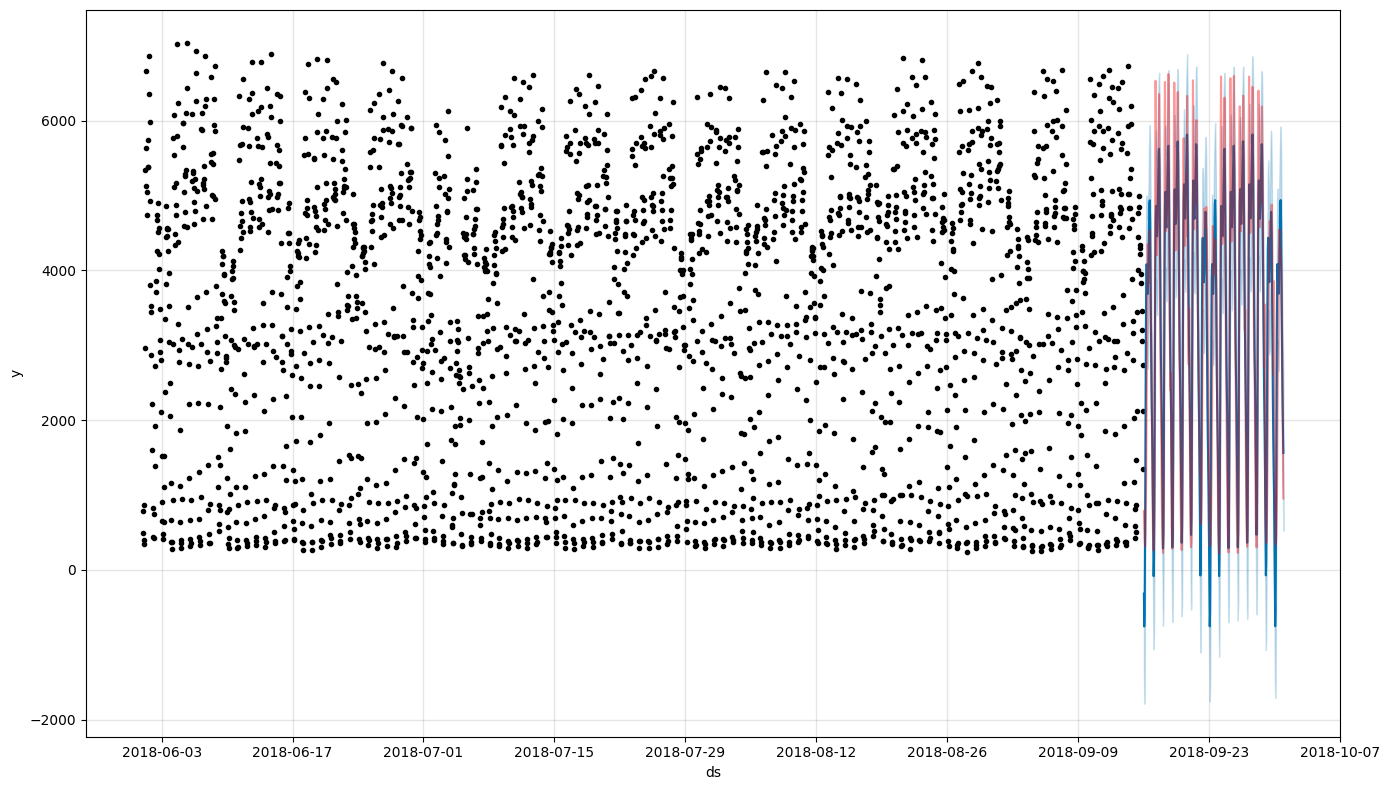

In [251]:
fig2 = fbmodel.plot(forecast, figsize=(14,8))
plt.plot(fb_y_test["ds"], fb_y_test["y"], c="r", alpha=0.4)
plt.show()

In [252]:
plot_plotly(fbmodel, forecast)

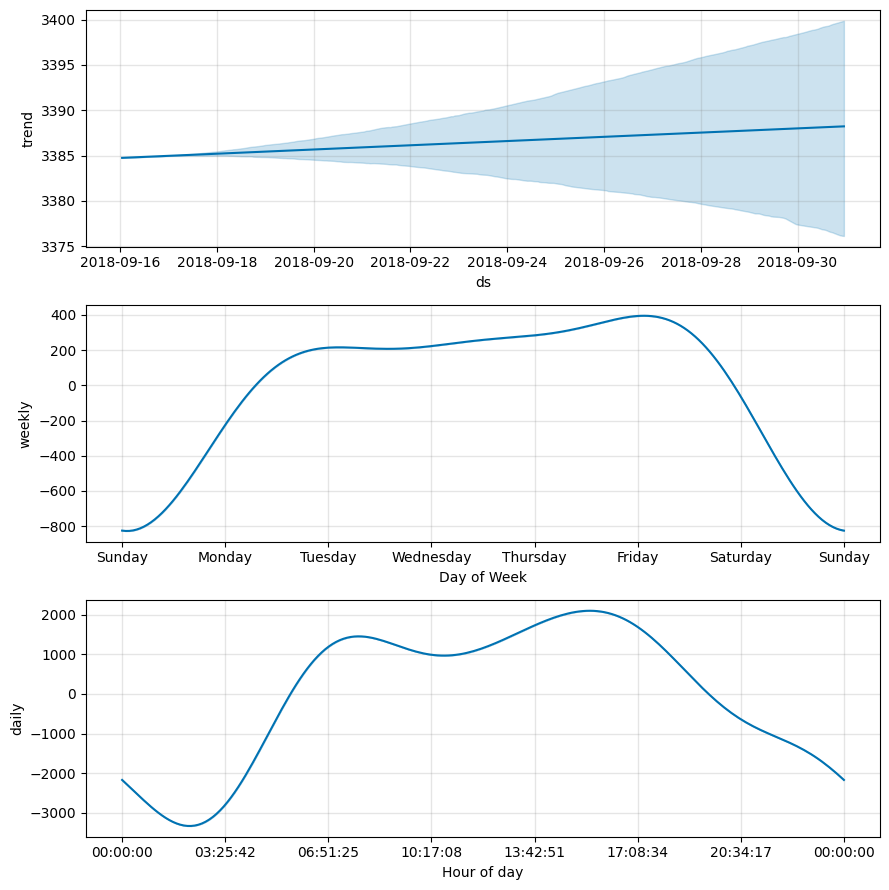

In [253]:
_ = fbmodel.plot_components(forecast)

# ARIMA

In [254]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [255]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

In [256]:
adf_test = ADFTest(alpha=0.5)
adf_test.should_diff(df.traffic_volume)

(0.01, False)

In [257]:
df_arima = pd.DataFrame()
df_arima["ds"] = pd.to_datetime(df.index)
df_arima["y"] = df['traffic_volume'].values

arima_y_train = df_arima.iloc[:-359].copy()
arima_y_test = df_arima.iloc[-359:].copy()
arima_y_val = arima_y_test[["ds"]].copy()

In [258]:
arima_y_train = arima_y_train.drop(['ds'], axis=1)
arima_y_train

,y
0,786.0
1,497.0
2,346.0
3,395.0
4,872.0
...,...
2559,3208.0
2560,3055.0
2561,2741.0
2562,2123.0


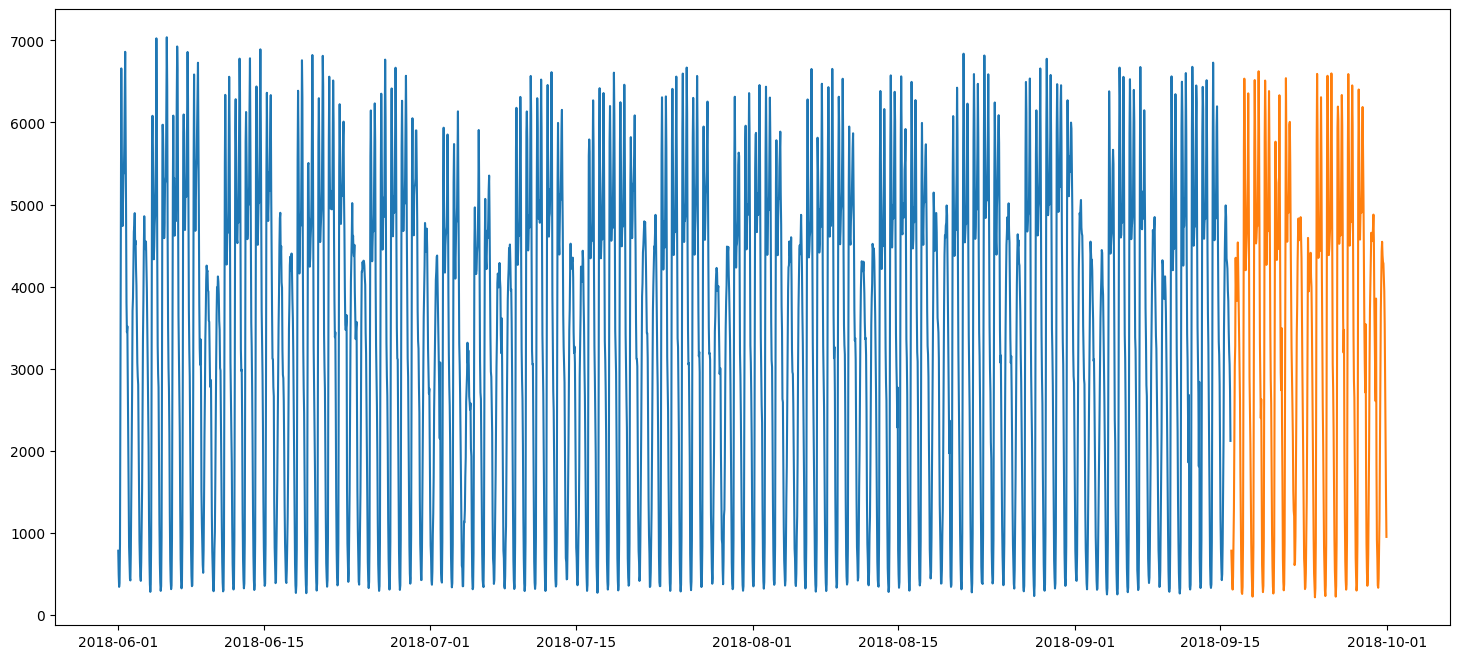

In [259]:
plot_data(df_arima)

In [272]:
arima_model = auto_arima(y_train, start_p=1, d=1, start_q=1,
                         max_p=1, max_d=1, max_q=1, start_P=0,
                         D=1, start_Q=0, max_P=1, max_D=1,
                         max_Q=1, m=24, seasonal=True, error_action='warn',
                         trace=True, suppress_warnings=True, stepwise=True,
                         random_state=42, n_fits=50)
# arima_model = auto_arima(y_train,
#                       start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=12,             # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=True,    # Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[24]             : AIC=38603.117, Time=1.55 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=39099.861, Time=0.40 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=38557.656, Time=5.19 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=10.90 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=38677.934, Time=0.27 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=16.65 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=inf, Time=9.05 sec
 ARIMA(0,1,0)(1,1,0)[24]             : AIC=39059.038, Time=1.69 sec
 ARIMA(1,1,1)(1,1,0)[24]             : AIC=38443.215, Time=7.89 sec
 ARIMA(1,1,1)(1,1,1)[24]             : AIC=inf, Time=22.84 sec
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=inf, Time=16.41 sec
 ARIMA(0,1,1)(1,1,0)[24]             : AIC=38479.356, Time=4.95 sec
 ARIMA(1,1,1)(1,1,0)[24] intercept   : AIC=38445.215, Time=19.96 sec

Best model:  ARIMA(1,1,1)(1,1,0)[24]          
Total fit time: 117.790 seconds


In [273]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2563
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 24)   Log Likelihood              -19217.607
Date:                             Mon, 03 Apr 2023   AIC                          38443.215
Time:                                     09:33:03   BIC                          38466.572
Sample:                                          0   HQIC                         38451.688
                                            - 2563                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2086      0.028      7.388      0.000       0.153       0.264
ma.L1          0.3250      0.030     10.944      0.000       0.267       0.383
ar.S.L24      -0.2617      0.017    -15.760      0.000      -0.294      -0.229
sigma2      2.212e+05   3882.998     56.956      0.000    2.14e+05    2.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):              1491.99
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.11
Prob(H) (two-sided):                  0.43   Kurtosis:                         6.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [282]:
prediction = pd.DataFrame(arima_model.predict(n_periods=359))
prediction.columns = ['predicted_traffic_volume']
prediction.head(10)

,predicted_traffic_volume
2563,1414.755731
2564,1094.630889
2565,920.754451
2566,817.673877
2567,1007.215582
2568,1804.950815
2569,2945.256182
2570,3727.000213
2571,4497.399072
2572,4670.706054


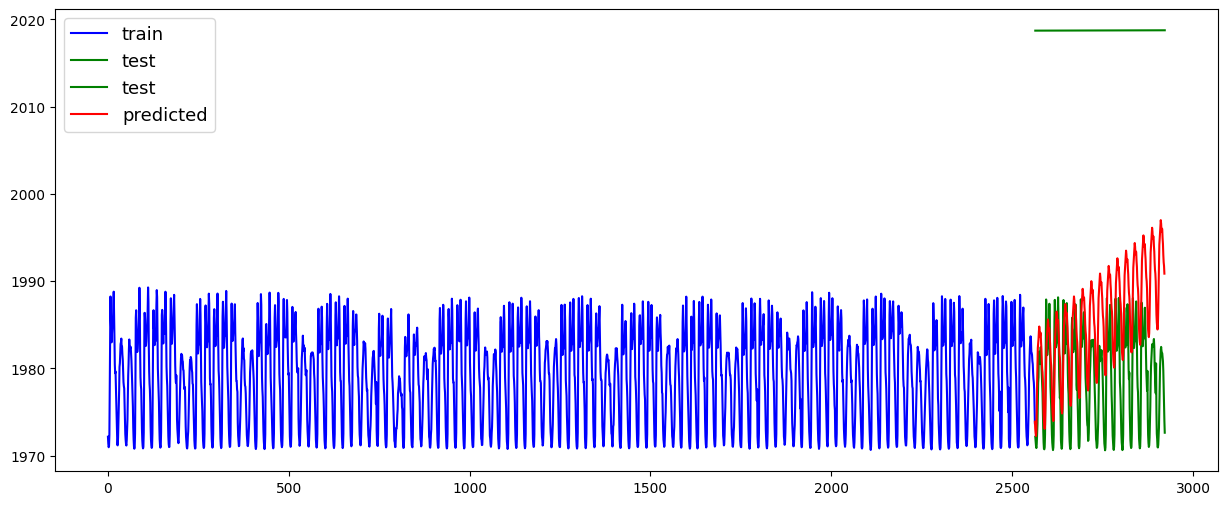

In [283]:
plt.figure(figsize=(15,6))
plt.plot(arima_y_train, 'b', label="train")
plt.plot(arima_y_test, 'g', label="test")
plt.plot(prediction, 'r', label="predicted")
plt.legend(loc='upper left', fontsize=13)
plt.show()

In [286]:
r2_score(y_test, prediction)

-1.4994773688482517

In [ ]:
# error_metrics(y_test, prediction)

In [ ]:
# def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
#     """
#     Plot time series, its ACF and PACF, calculate Dickey–Fuller test
#     :param y:     Timeseries
#     :param lags:  How many lags to include in ACF, PACF calculation
#     """
#     if not isinstance(y, pd.Series):
#         y = pd.Series(y)
        
#     with plt.style.context(style):    
#         fig = plt.figure(figsize=figsize)
#         layout = (2, 2)
#         ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
#         acf_ax = plt.subplot2grid(layout, (1, 0))
#         pacf_ax = plt.subplot2grid(layout, (1, 1))
        
#         y.plot(ax=ts_ax)
#         p_value = sm.tsa.stattools.adfuller(y)[1]
#         ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
#         smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
#         smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
#         plt.tight_layout()

In [ ]:
# import statsmodels.formula.api as smf
# import statsmodels.tsa.api as smt
# import statsmodels.api as sm

# tsplot(df['traffic_volume'], lags=30)

In [ ]:
# # Конечная разность (первого порядка, численное дифференцирование)
# _diff_1 = df['traffic_volume'].values[1:] - df['traffic_volume'].values[:-1]
# tsplot(_diff_1, lags=30)

In [ ]:
# from scipy.optimize import minimize
# from scipy.stats import boxcox
# from scipy.special import inv_boxcox


# # Преобразование к стационарному виду (преобразование Бокса-Кокса)
# # автокорреляционная функция показывает сезонность
# transfromed_series_a, bc_lamb = boxcox(df['traffic_volume'])

# tsplot(transfromed_series_a, lags=30)

In [ ]:
# Разность первого порядка (критерий Дики-Фуллера отвергает гипотезу, но в пограничных значениях)
# При этом автокорреляционная функция показывает сезонность
# tsplot(transfromed_series_a[1:] - transfromed_series_a[:-1], lags=30)

In [ ]:
# # + Сезонная разность
# diff = transfromed_series_a[1:] - transfromed_series_a[:-1]

# seasons = 12

# tsplot(diff[seasons:] - diff[:-seasons], lags=30)

In [ ]:
# def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
#     """
#     Plots model vs predicted values
#     :param series:   Dataset with timeseries
#     :type series:     pd.DataFrame
#     :param model:    Fitted SARIMA model
#     :type model:      sm.tsa.statespace.SARIMAX
#     :param n_steps:  Number of steps to predict in the future
#     :type n_steps:    int
#     """
#     # adding model values
#     data = series.copy()
#     data.columns = ['actual']
#     data['arima_model'] = model.fittedvalues
#     # making a shift on s+d steps, because these values were unobserved by the model
#     # due to the differentiating
#     data['arima_model'][:s+d] = np.NaN
    
#     # forecasting on n_steps forward 
#     forecast = model.get_forecast(steps=n_steps)
#     model_predictions = data.arima_model.append(forecast.predicted_mean)
#     # calculate error, again having shifted on s+d steps from the beginning
#     error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
#     plt.figure(figsize=(15, 7))
#     plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
#     plt.plot(model_predictions, color='r', label="model")
#     plt.plot(data.actual, label="actual")
    
#     if plot_intervals:
#         intervals = forecast.conf_int(alpha=alpha)
#         intervals.columns=['lower', 'upper']
#         plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
#         plt.plot(intervals['upper'], "r--", alpha=0.5)
#         plt.fill_between(x=intervals.index, y1=intervals['upper'],
#                          y2=intervals['lower'], alpha=0.2, color = "grey")
    
#     plt.legend()
#     plt.grid(True)

In [ ]:
# def optimizeSARIMA(data, parameters_list, d, D, s):
#     """
#     Return dataframe with parameters and corresponding AIC
#     :param parameters_list:  list with (p, q, P, Q) tuples
#     :type parameters_list:    list
#     :param d:                integration order in ARIMA model
#     :type d:                  int
#     :param D:                seasonal integration order
#     :type D:                  int
#     :param s:                length of season
#     :type s:                  int
#     """
#     results = []
#     best_aic = float("inf")

#     for param in tqdm_notebook(parameters_list):
#         # we need try-except because on some combinations model fails to converge
#         try:
#             model = sm.tsa.statespace.SARIMAX(data,
#                 order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
#         except:
#             continue
        
#         aic = model.aic
#         if aic < best_aic:
#             best_model = model
#             best_aic = aic
#             best_param = param
#         results.append([param, model.aic])

#     result_table = pd.DataFrame(results)
#     result_table.columns = ['parameters', 'aic']
    
#     # sorting in ascending order, the lower AIC is - the better
#     result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
#     return result_table

In [ ]:
# p, d, q = 1, 1, 1
# P, D, Q = 0, 1, 0
# s = 12

# model = sm.tsa.statespace.SARIMAX(df.traffic_volume,
#                                   order=(p, d, q),
#                                   seasonal_order=(P, D, Q, s)).fit(disp=-1)

# plotSARIMA(df, model, n_steps=50, s=s, d=d, plot_intervals=True, alpha=0.5)